In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
import qiskit.quantum_info as qi
from numpy import pi, random, sqrt
import numpy as np
from qiskit.quantum_info import Statevector, Operator

In [6]:
state = QuantumRegister(5, name="|ψ>")

circuit = QuantumCircuit(state)
"""
circuit.u(theta = random.random() * 2 * pi,
    phi = random.random() * 2 * pi,
    lam = random.random() * 2 * pi,
    qubit = state[0])
"""


'\ncircuit.u(theta = random.random() * 2 * pi,\n    phi = random.random() * 2 * pi,\n    lam = random.random() * 2 * pi,\n    qubit = state[0])\n'

Encoding

In [7]:
encoding = QuantumCircuit(5)

circuit.z(state[0])

encoding.h([1])
encoding.cz([1], [2, 4])
encoding.cx([1], [0])

encoding.h([4])
encoding.cz([4], [1, 3])
encoding.cx([4], [0])

encoding.h([3])
encoding.cz([3], [0, 2])
encoding.cx([3], [4])

encoding.h([2])
encoding.cz([2], [1, 4])
encoding.cx([2], [3])

decoding = encoding.inverse()
circuit = circuit.compose(encoding, qubits=state)

ancilla = QuantumRegister(4, name="A")

syndrome = ClassicalRegister(4, name="S")

circuit.add_register(ancilla)
circuit.add_register(syndrome)

In [8]:

circuit.h(ancilla)

i,j = 2,3
m,n = 1,4

for k in range(4):
    circuit.cx(ancilla[k], [state[i % len(state)], state[j % len(state)]])
    circuit.cz(ancilla[k], [state[m % len(state)], state[n % len(state)]])
    i,j,m,n = i+1,j+1,m+1,n+1
    

circuit.h(ancilla)
circuit.measure(ancilla, syndrome)


In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile

service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(circuit)

sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit])

result = job.result()

QiskitBackendNotFoundError: 'No backend matches the criteria.'

In [23]:
result = AerSimulator().run(circuit).result()
statistics = result.get_counts()
synd = bin(0)
for k,v in statistics.items():
    #print(k)
    synd = k

Syndrome Table:
X0 : 0010
X1 : 0101
X2 : 1010
X3 : 0100
X4 : 1001

Z0 : 1100
Z1 : 1000
Z2 : 0001
Z3 : 0011
Z4 : 0110

Y0 : 1110
Y1 : 1101
Y2 : 1011
Y3 : 0111
Y4 : 1111

Error Correction:

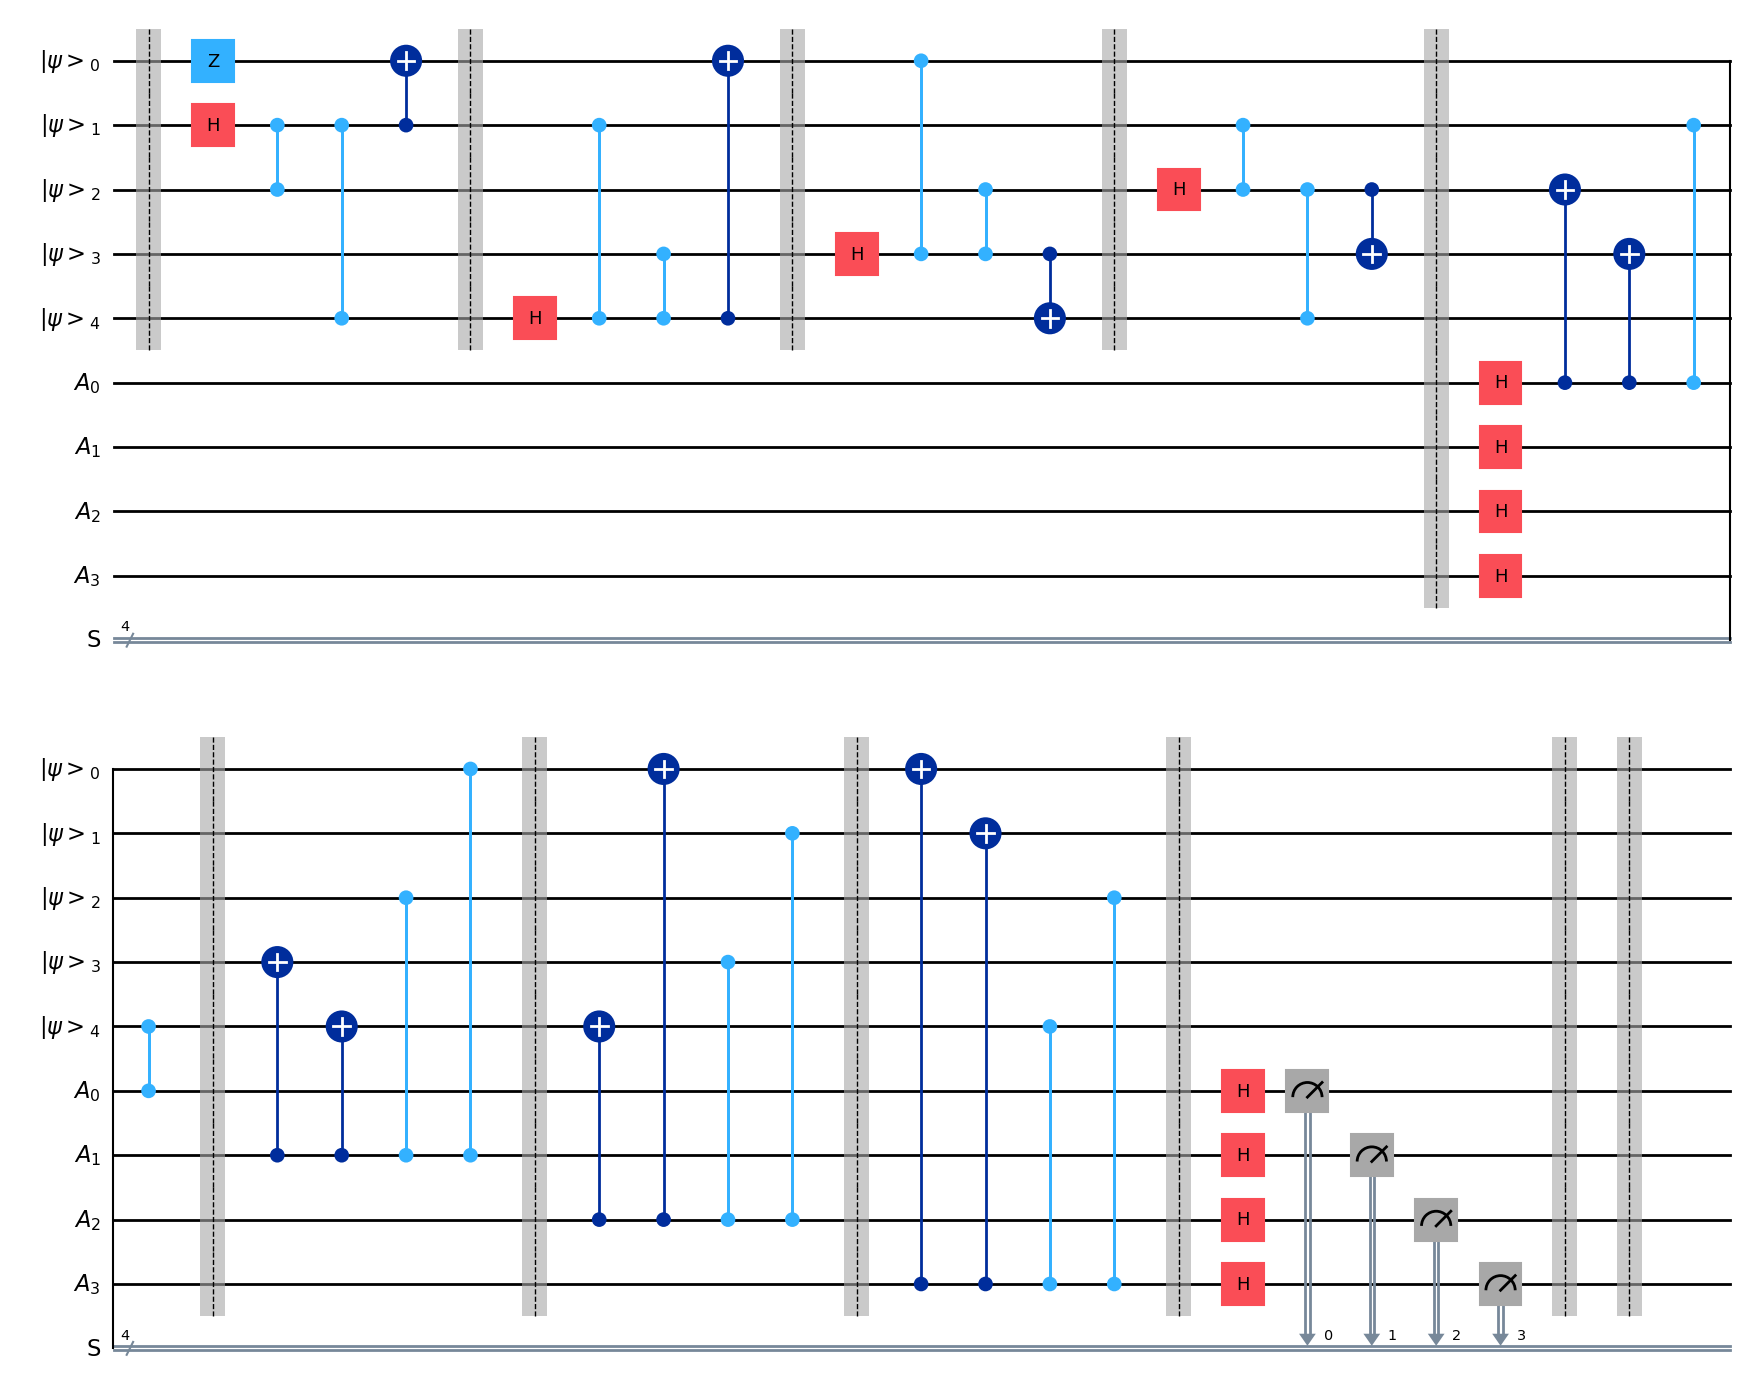

In [24]:
x_list = ['0010', '0101', '1010', '0100', '1001']
z_list = ['1100', '1000', '0001', '0011', '0110']
y_list = ['1110', '1101', '1011', '0111', '1111']
total_list = [x_list, z_list, y_list]

circuit.barrier()

for type, list in enumerate(total_list):
    for index, item in enumerate(list):
        if synd == item:
            if type == 0:
                circuit.x(state[index])
            if type == 1:
                circuit.z(state[index])
            if type == 2:
                circuit.x(state[index])
                circuit.z(state[index])

circuit.barrier()
display(circuit.draw(output='mpl'))

In [25]:
circuit = circuit.compose(decoding, qubits=state)

final_state = ClassicalRegister(1)
circuit.add_register(final_state)
circuit.measure(state[0], final_state)

In [26]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
# Define a local backend
from qiskit.providers.fake_provider import GenericBackendV2
backend = GenericBackendV2(num_qubits=9)

transpiled_circuit = transpile(circuit, backend)
 
# Run the transpiled circuit using the simulated backend
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()



None

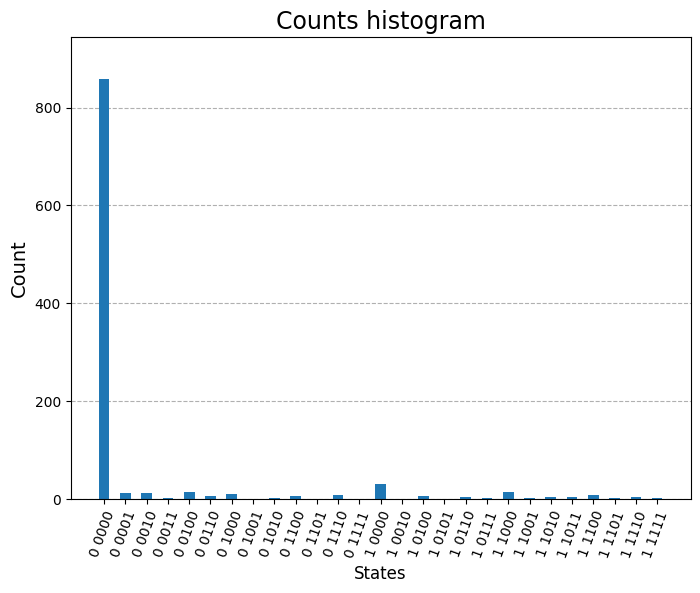

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_title("5qubit Fake Backend", fontsize=15)
ax.set_xlabel("States", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)

display(plot_histogram(counts, bar_labels=False, ax=ax))


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile

service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(circuit)

sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit])

result = job.result()